In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

import pickle
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from cmap import Colormap
from sort_src.sort import SORT
from sort_src.sort_utils import flier_mask, x_univar


## Walking stem library design

I ran the following Python script that designs the walking stem library for any input sequence. Note that insert length and stem layout are currently hard-coded (sorry). This code is very specialized and it will take a lot to generalize it.

```bash
python design_walking_stem.py -exon1 CAUAAACAAACAAAUCUAGAAUGUACCCAUACGAUGUUCCUGACUAUGCUGGUUCUGCAG -exon2 GUGUCUCUAAGGGUGAAGAAGAUAACAUGGCUUCUUUGCCAGCCACCCACGAGUUGCACA -intron GUAUGUUUUUAAUAUUUUAGAUGCUCUUUGCUUCUCCGAGAGACGUUAGUUCCUUUUUUACUAACAACUUACUUUUCACUAG -s_mask 1111110000000000000000000000000000000000000000000000000000000000000000000000000011 -n_cpu 16 -o got1_design_2_3.pkl 
```

```python
#!/bin/env/python

import pickle
import numpy as np
from sort_src.design_utils import antarna_design, get_destab_muts
from sort_src.fold_utils import vienna_bp_prob
from multiprocessing import Pool
import argparse
from tqdm import tqdm

def anarna_pos(Cseq, Cstr_target_l, Cstr_contrl_l, Cstr_target_r, Cstr_contrl_r, n_target_hps=2):
    seq_target_l = antarna_design(Cseq, Cstr_target_l, n_target_hps)
    seq_contrl_l = antarna_design(Cseq, Cstr_contrl_l, 5)
    seq_target_r = antarna_design(Cseq, Cstr_target_r, n_target_hps)
    seq_contrl_r = antarna_design(Cseq, Cstr_contrl_r, 5)

    return(seq_target_l, seq_contrl_l, seq_target_r, seq_contrl_r, Cseq)



def design(exon1, exon2, intron, s_mask, n_target_hps, n_destab_hps, n_cpu, out_name):

    # target stem loop input
    target_stem = '.(((((((((((((....))))))))))))).'
    contrl_stem = '................................'
    insert_strt = 18
    insert_size = 19

    seqs_target_l = []
    seqs_contrl_l = []
    seqs_target_r = []
    seqs_contrl_r = []
    seqs_cseq     = []

    Cseqs = [exon1 + intron[:pos] + 'N'*insert_size + intron[pos:] + exon2 for pos in range(len(intron)) if s_mask[pos] != '1']
    Cstr_target_ls = ['a'*(len(exon1+intron[:pos])-len(target_stem)+insert_strt) + target_stem + 'b' + 'b'*len(intron[pos:]+exon2) for pos in range(len(intron)) if s_mask[pos] != '1']
    Cstr_contrl_ls = ['a'*(len(exon1+intron[:pos])-len(contrl_stem)+insert_strt) + contrl_stem + 'b' + 'b'*len(intron[pos:]+exon2) for pos in range(len(intron)) if s_mask[pos] != '1']
    Cstr_target_rs = ['a'*len(exon1+intron[:pos]) + 'a' + target_stem + 'b'*(len(intron[pos:]+exon2)-len(target_stem)+insert_strt) for pos in range(len(intron)) if s_mask[pos] != '1']
    Cstr_contrl_rs = ['a'*len(exon1+intron[:pos]) + 'a' + contrl_stem + 'b'*(len(intron[pos:]+exon2)-len(contrl_stem)+insert_strt) for pos in range(len(intron)) if s_mask[pos] != '1']

    vars_iterable = [(Cseqs[i], Cstr_target_ls[i], Cstr_contrl_ls[i], Cstr_target_rs[i], Cstr_contrl_rs[i], n_target_hps) for i in range(len(Cseqs))]
    with Pool(processes=n_cpu) as pool:
        for (seq_target_l, seq_contrl_l, seq_target_r, seq_contrl_r, Cseq) in pool.starmap(anarna_pos, vars_iterable):
            seqs_target_r.append(seq_target_r)
            seqs_contrl_r.append(seq_contrl_r)
            seqs_target_l.append(seq_target_l)
            seqs_contrl_l.append(seq_contrl_l)
            seqs_cseq.append(Cseq)

    seqs_destab_r = get_destab_muts(seqs_target_r, seqs_cseq, n_destab_hps, destab_side='left', RNAFramework_path='/gpfs/gibbs/project/neugebauer/ls2286/build/RNAFramework', ViennaRNA_path='/gpfs/gibbs/project/neugebauer/ls2286/build/ViennaRNA-2.6.4/src/bin/RNAfold', perl5_lib='/gpfs/gibbs/project/neugebauer/ls2286/build/ViennaRNA-2.6.4/interfaces/Perl/')
    seqs_destab_l = get_destab_muts(seqs_target_l, seqs_cseq, n_destab_hps, destab_side='right', RNAFramework_path='/gpfs/gibbs/project/neugebauer/ls2286/build/RNAFramework', ViennaRNA_path='/gpfs/gibbs/project/neugebauer/ls2286/build/ViennaRNA-2.6.4/src/bin/RNAfold', perl5_lib='/gpfs/gibbs/project/neugebauer/ls2286/build/ViennaRNA-2.6.4/interfaces/Perl/')

    pps_destab_l = []
    for seqss in tqdm(seqs_destab_l):
        for seqs in seqss:
            for seq in seqs:
                pp = vienna_bp_prob(seq)
                pps_destab_l.append(pp)
    pps_destab_r = []
    for seqss in tqdm(seqs_destab_r):
        for seqs in seqss:
            for seq in seqs:
                pp = vienna_bp_prob(seq)
                pps_destab_r.append(pp)
    pps_target_l = []
    for seqs in tqdm(seqs_target_l):
        for seq in seqs:
            pp = vienna_bp_prob(seq)
            pps_target_l.append(pp)
    pps_target_r = []
    for seqs in tqdm(seqs_target_r):
        for seq in seqs:
            pp = vienna_bp_prob(seq)
            pps_target_r.append(pp)
    pps_contrl_l = []
    for seqs in tqdm(seqs_contrl_l):
        for seq in seqs:
            pp = vienna_bp_prob(seq)
            pps_contrl_l.append(pp)
    pps_contrl_r = []
    for seqs in tqdm(seqs_contrl_r):
        for seq in seqs:
            pp = vienna_bp_prob(seq)
            pps_contrl_r.append(pp)

    with open(out_name, 'wb') as f:
        pickle.dump([(seqs_target_l, seqs_contrl_l, seqs_destab_l, seqs_target_r, seqs_contrl_r, seqs_destab_r, seqs_cseq),
                     (pps_target_l ,  pps_contrl_l,  pps_destab_l,  pps_target_r,  pps_contrl_r, pps_destab_r)], f)


if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('-exon1', help='exon1 sequence', type=str)
    parser.add_argument('-exon2', help='exon2 sequence', type=str)
    parser.add_argument('-intron', help='intron sequence', type=str)
    parser.add_argument('-s_mask', help='intron mask', type=str)
    parser.add_argument('-n_target', help='number of target hairpins at each position', type=int)
    parser.add_argument('-n_destab', help='number of destabilized mutants for each target hairpin', type=int)
    parser.add_argument('-n_cpu', help='number of cores', type=int)
    parser.add_argument('-o', help='Output file name.', type=str)
    args = parser.parse_args()

    if not args.n_cpu:
        args.n_cpu = 1

    design(args.exon1, args.exon2, args.intron, args.s_mask, args.n_target, args.n_destab, args.n_cpu, args.o)

```

## Figure 3b

In [3]:
# load walking stem design data
with open('../data/miscellaneous/walking_got1_t3_d2_1.pkl', 'rb') as f:
    seqs, pps = pickle.load(f)
seqs_target_l, seqs_contrl_l, seqs_destab_l, seqs_target_r, seqs_contrl_r, seqs_destab_r, seqs_cseq = seqs 
pps_target_l , pps_contrl_l , pps_destab_l , pps_target_r , pps_contrl_r , pps_destab_r             = pps

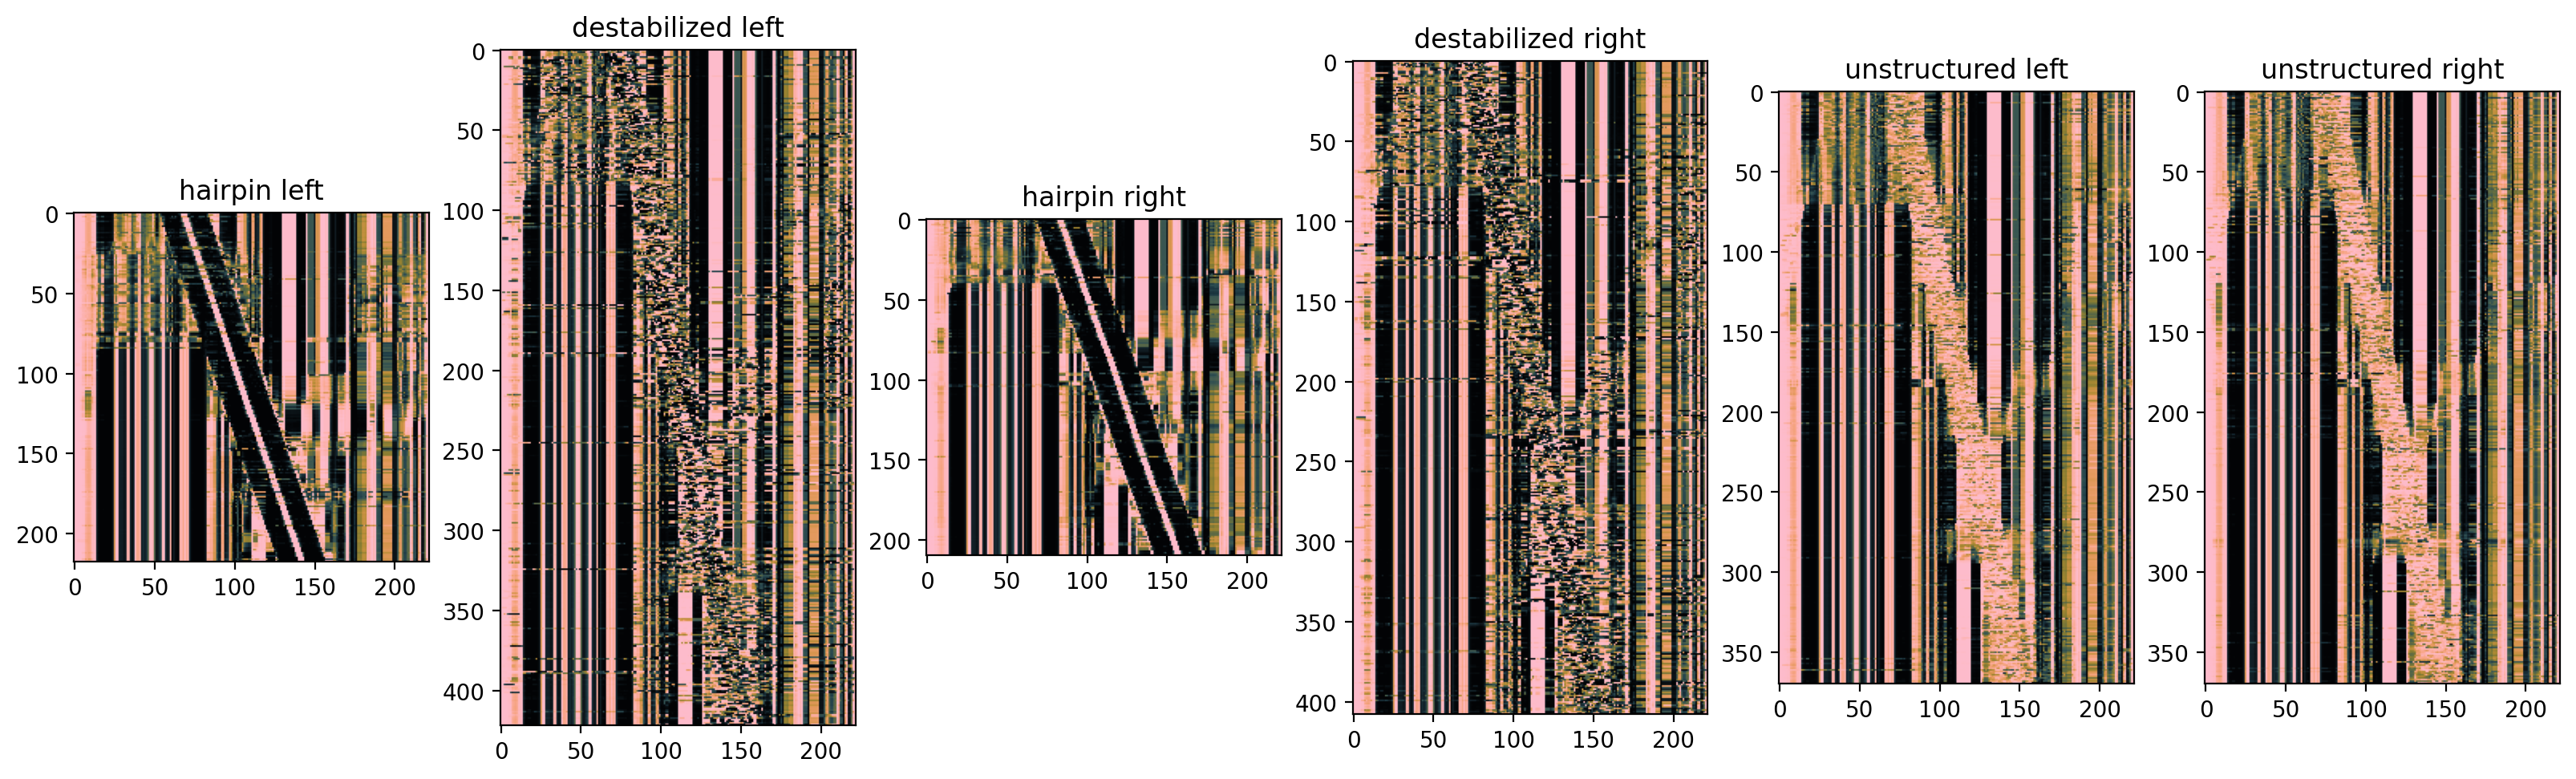

In [4]:
fig, axs = plt.subplots(1, 6, figsize=(20, 20))
axs = axs.flatten()

cmap = Colormap('batlowk_r').to_mpl()
axs[0].imshow(pps_target_l, vmin=-0.1, vmax=1, cmap=cmap)
axs[0].set_title('hairpin left')
axs[1].imshow(pps_destab_l, vmin=-0.1, vmax=1, cmap=cmap)
axs[1].set_title('destabilized left')
axs[2].imshow(pps_target_r, vmin=-0.1, vmax=1, cmap=cmap)
axs[2].set_title('hairpin right')
axs[3].imshow(pps_destab_r, vmin=-0.1, vmax=1, cmap=cmap)
axs[3].set_title('destabilized right')
axs[4].imshow(pps_contrl_l, vmin=-0.1, vmax=1, cmap=cmap)
axs[4].set_title('unstructured left')
axs[5].imshow(pps_contrl_r, vmin=-0.1, vmax=1, cmap=cmap)
axs[5].set_title('unstructured right')

plt.show()

## Figure 3c

In [5]:
# load Sort-seq data
wsl = SORT('../config/sortseq_csvs/walking_stem.csv', '../config/fasta_files/walking_stem.fasta')
wsl.load_flow_data()
wsl.load_seq_data(min_reads=10, cutoff=0.7, n_cpu=8)

/Users/leo/Documents/repos/intron_sortseq/sort_src/sort_utils.py:18: RuntimeWarning: invalid value encountered in divide
  sort_mat_scaled = sort_mat_scaled/np.sum(sort_mat_scaled, axis=1)[:,None]


In [6]:
# sort out sub-libraries
orig_seq = 'CAUAAACAAACAAAUCUAGAAUGUACCCAUACGAUGUUCCUGACUAUGCUGGUUCUGCAGGUAUGUUUUUAAUAUUUUAGAUGCUCUUUGCUUCUCCGAGAGACGUUAGUUCCUUUUUUACUAACAACUUACUUUUCACUAGGUGUCUCUAAGGGUGAAGAAGAUAACAUGGCUUCUUUGCCAGCCACCCACGAGUUGCACA'

targL_nam = [i for i in wsl.sort_df['Name'] if 'targL' in i and not 'dest' in i]
targL_fluo = wsl.sort_df.filter(pl.col("Name").is_in(targL_nam)).get_column("mu_est").to_numpy()
targL_x = [int(i.split('_')[1]) for i in targL_nam]
targL_mean = np.full(len(orig_seq), np.nan)
targL_stad = np.full(len(orig_seq), np.nan)
for pos in np.unique(targL_x):
    targL_mean[66+pos] = np.nanmean(targL_fluo[targL_x == pos])
    targL_stad[66+pos] = np.nanstd(targL_fluo[targL_x == pos])

destL_nam = [i for i in wsl.sort_df['Name'] if 'destL' in i]
destL_fluo = wsl.sort_df.filter(pl.col("Name").is_in(destL_nam)).get_column("mu_est").to_numpy()
destL_x = [int(i.split('_')[1]) for i in destL_nam]
destL_mean = np.full(len(orig_seq), np.nan)
destL_stad = np.full(len(orig_seq), np.nan)
for pos in np.unique(destL_x):
    destL_mean[66+pos] = np.nanmean(destL_fluo[destL_x == pos])
    destL_stad[66+pos] = np.nanstd(destL_fluo[destL_x == pos])

unstL_nam = [i for i in wsl.sort_df['Name'] if 'unstL' in i]
unstL_fluo = wsl.sort_df.filter(pl.col("Name").is_in(unstL_nam)).get_column("mu_est").to_numpy()
unstL_x = [int(i.split('_')[1]) for i in unstL_nam]
unstL_mean = np.full(len(orig_seq), np.nan)
unstL_stad = np.full(len(orig_seq), np.nan)
for pos in np.unique(unstL_x):
    unstL_mean[66+pos] = np.nanmean(unstL_fluo[unstL_x == pos])
    unstL_stad[66+pos] = np.nanstd(unstL_fluo[unstL_x == pos])

targR_nam = [i for i in wsl.sort_df['Name'] if 'targR' in i and not 'dest' in i]
targR_fluo = wsl.sort_df.filter(pl.col("Name").is_in(targR_nam)).get_column("mu_est").to_numpy()
targR_x = [int(i.split('_')[1]) for i in targR_nam]
targR_mean = np.full(len(orig_seq), np.nan)
targR_stad = np.full(len(orig_seq), np.nan)
for pos in np.unique(targR_x):
    targR_mean[66+pos] = np.nanmean(targR_fluo[targR_x == pos])
    targR_stad[66+pos] = np.nanstd(targR_fluo[targR_x == pos])

destR_nam = [i for i in wsl.sort_df['Name'] if 'destR' in i]
destR_fluo = wsl.sort_df.filter(pl.col("Name").is_in(destR_nam)).get_column("mu_est").to_numpy()
destR_x = [int(i.split('_')[1]) for i in destR_nam]
destR_mean = np.full(len(orig_seq), np.nan)
destR_stad = np.full(len(orig_seq), np.nan)
for pos in np.unique(destR_x):
    destR_mean[66+pos] = np.nanmean(destR_fluo[destR_x == pos])
    destR_stad[66+pos] = np.nanstd(destR_fluo[destR_x == pos])

unstR_nam = [i for i in wsl.sort_df['Name'] if 'unstR' in i]
unstR_fluo = wsl.sort_df.filter(pl.col("Name").is_in(unstR_nam)).get_column("mu_est").to_numpy()
unstR_x = [int(i.split('_')[1]) for i in unstR_nam]
unstR_mean = np.full(len(orig_seq), np.nan)
unstR_stad = np.full(len(orig_seq), np.nan)
for pos in np.unique(unstR_x):
    unstR_mean[66+pos] = np.nanmean(unstR_fluo[unstR_x == pos])
    unstR_stad[66+pos] = np.nanstd(unstR_fluo[unstR_x == pos])




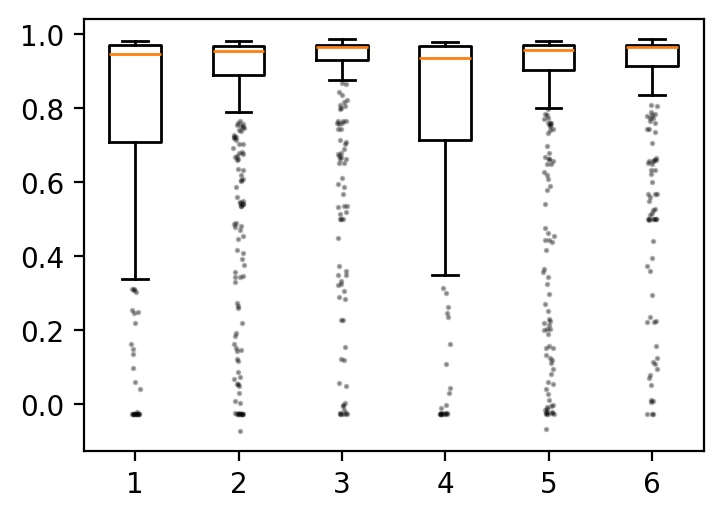

In [7]:
plt.figure(figsize=[4,2.8])

sub_libs = [targL_fluo, destL_fluo, unstL_fluo, targR_fluo, destR_fluo, unstR_fluo]
plt.boxplot([i[np.isfinite(i)] for i in sub_libs], widths=0.5, showfliers=False)

for i, ds in enumerate(sub_libs):
    ds = ds[np.isfinite(ds)]
    fliers = ds[flier_mask(ds)]
    plt.plot(np.repeat(i+1, len(fliers)) + x_univar(len(fliers), spread=0.1), fliers, '.k', alpha=0.3, ms=2)

plt.show()

## Figure 3d

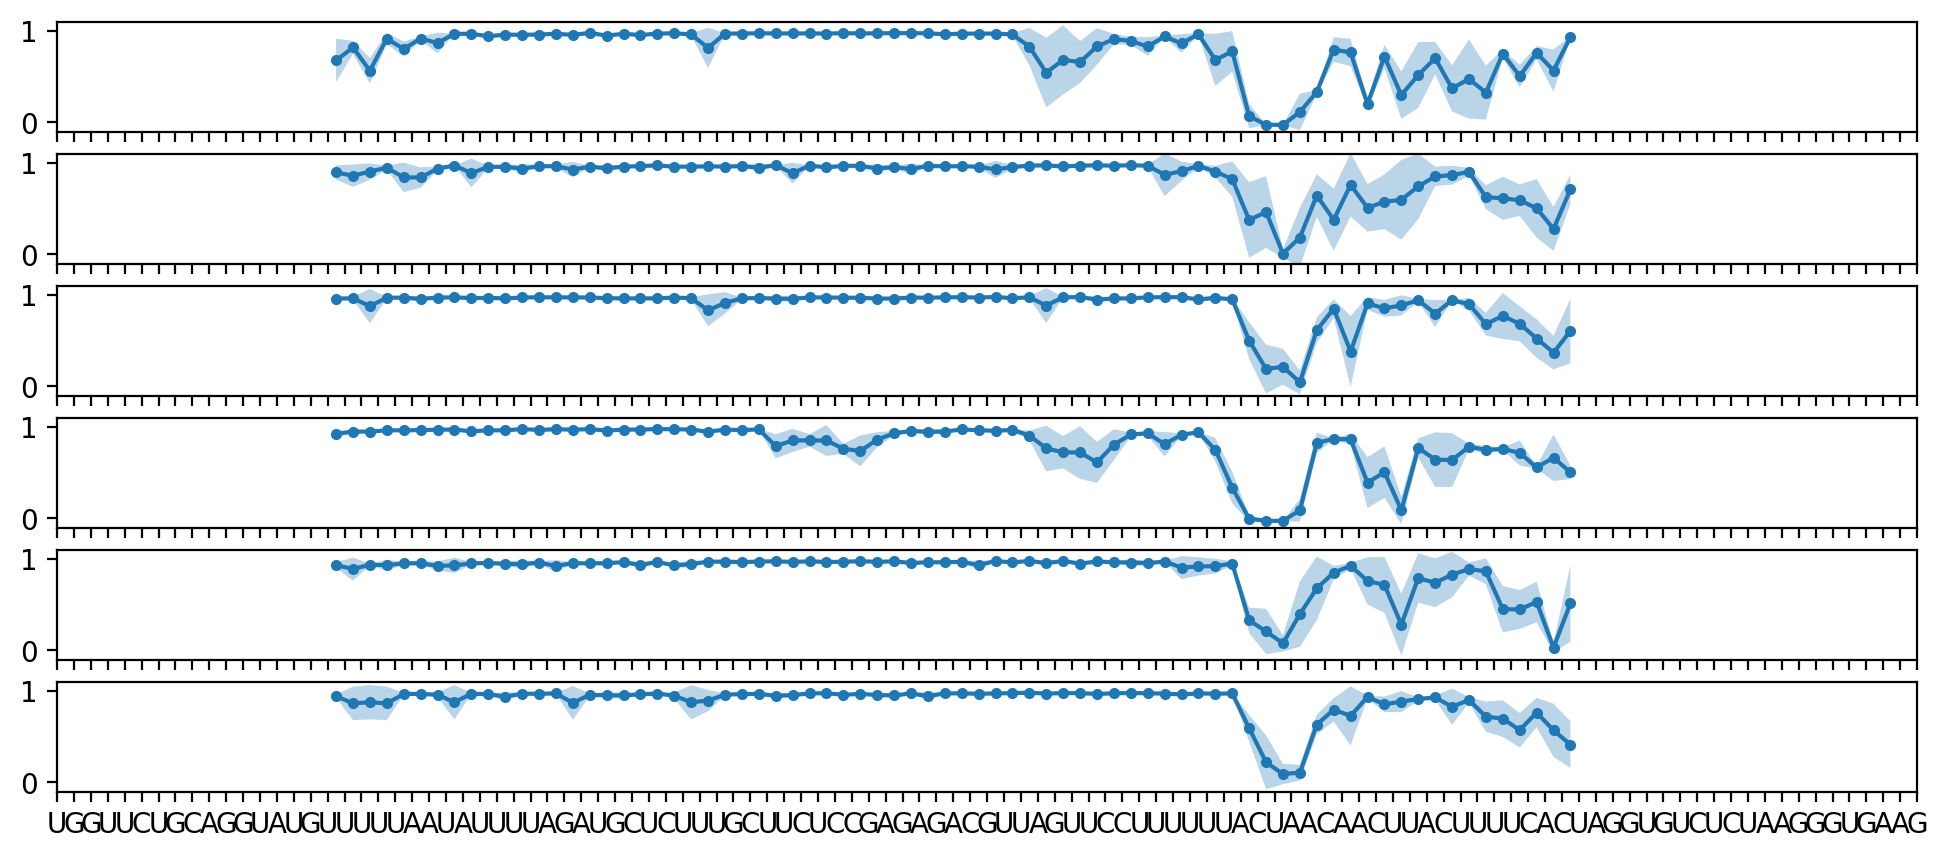

In [8]:
fig, axs = plt.subplots(6, 1, figsize=(12,5), sharex=True, sharey=True)
# Left sequestered variants 
axs[0].plot(np.arange(len(orig_seq))-0.5, targL_mean, '.-')
axs[0].fill_between(np.arange(len(orig_seq))-0.5, targL_mean - targL_stad, targL_mean + targL_stad, alpha=0.3)
axs[1].plot(np.arange(len(orig_seq))-0.5, destL_mean, '.-')
axs[1].fill_between(np.arange(len(orig_seq))-0.5, destL_mean - destL_stad, destL_mean + destL_stad, alpha=0.3)
axs[2].plot(np.arange(len(orig_seq))-0.5, unstL_mean, '.-')
axs[2].fill_between(np.arange(len(orig_seq))-0.5, unstL_mean - unstL_stad, unstL_mean + unstL_stad, alpha=0.3)

# Right sequestered variants 
axs[3].plot(np.arange(len(orig_seq))-0.5, targR_mean, '.-')
axs[3].fill_between(np.arange(len(orig_seq))-0.5, targR_mean - targR_stad, targR_mean + targR_stad, alpha=0.3)
axs[4].plot(np.arange(len(orig_seq))-0.5, destR_mean, '.-')
axs[4].fill_between(np.arange(len(orig_seq))-0.5, destR_mean - destR_stad, destR_mean + destR_stad, alpha=0.3)
axs[5].plot(np.arange(len(orig_seq))-0.5, unstR_mean, '.-')
axs[5].fill_between(np.arange(len(orig_seq))-0.5, unstR_mean - unstR_stad, unstR_mean + unstR_stad, alpha=0.3)

axs[-1].set_xticks(np.arange(len(orig_seq))+1)
axs[-1].set_xticklabels(list(orig_seq))
plt.setp(axs, xlim=[50, 160], ylim=[-0.1, 1.1])
plt.show()

## Figure 3f

In [9]:
def score_wsl(targ, dest, unst, w=5):
    return((np.nanmedian( unst-targ ) + np.nanmedian( dest - targ))/(np.nanmedian(unst)+np.nanmedian(dest)))

blsc_targ_l =  [[] for _ in range(len(orig_seq))]
blsc_dest_l =  [[] for _ in range(len(orig_seq))]
blsc_unst_l =  [[] for _ in range(len(orig_seq))]
insertion_l =  [[] for _ in range(len(orig_seq))]
blsc_scor_l =  [[] for _ in range(len(orig_seq))]

for pos in np.unique(targL_x):
    for i, targ in enumerate(targL_fluo[targL_x == pos]):
        dest_nams = [f"pos_{pos}_targL_{i+1}_destL_{j+1}" for j in range(2)]
        unst_nams = [f"pos_{pos}_unstL_{j+1}" for j in range(np.sum(unstL_x==pos))]
        dest = wsl.sort_df.filter(pl.col('Name').is_in(dest_nams)).get_column('mu_est').to_list()
        unst = wsl.sort_df.filter(pl.col('Name').is_in(unst_nams)).get_column('mu_est').to_list()

        for l in range(60+5+pos-13, 60+5+pos):
            blsc_targ_l[l].append(targ)
            blsc_dest_l[l] += dest
            blsc_unst_l[l] += unst
            blsc_scor_l[l].append(score_wsl(np.array(targ), np.array(dest), np.array(unst)))
        

        insertion_l[60+5+pos] += unst
            
        
blsc_targ_r =  [[] for _ in range(len(orig_seq))]
blsc_dest_r=  [[] for _ in range(len(orig_seq))]
blsc_unst_r =  [[] for _ in range(len(orig_seq))]
insertion_r = [[] for _ in range(len(orig_seq))]
blsc_scor_r =  [[] for _ in range(len(orig_seq))]

for pos in np.unique(targR_x):
    for i, targ in enumerate(targR_fluo[targR_x == pos]):
        dest_nams = [f"pos_{pos}_targR_{i+1}_destR_{j+1}" for j in range(2)]
        unst_nams = [f"pos_{pos}_unstR_{j+1}" for j in range(np.sum(unstR_x==pos))]
        dest = wsl.sort_df.filter(pl.col('Name').is_in(dest_nams)).get_column('mu_est').to_list()
        unst = wsl.sort_df.filter(pl.col('Name').is_in(unst_nams)).get_column('mu_est').to_list()

        for l in range(60+5+pos, 60+5+pos+13):
            blsc_targ_r[l].append(targ)
            blsc_dest_r[l] += dest
            blsc_unst_r[l] += unst
            blsc_scor_r[l].append(score_wsl(np.array(targ), np.array(dest), np.array(unst)))

        insertion_r[60+5+pos] += unst


blsc_targ_l_mea = np.array([np.nanmean(i) for i in blsc_targ_l])
blsc_targ_l_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in blsc_targ_l])
blsc_dest_l_mea = np.array([np.nanmean(i) for i in blsc_dest_l])
blsc_dest_l_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in blsc_dest_l])
blsc_unst_l_mea = np.array([np.nanmean(i) for i in blsc_unst_l])
blsc_unst_l_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in blsc_unst_l])

blsc_targ_r_mea = np.array([np.nanmean(i) for i in blsc_targ_r])
blsc_targ_r_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in blsc_targ_r])
blsc_dest_r_mea = np.array([np.nanmean(i) for i in blsc_dest_r])
blsc_dest_r_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in blsc_dest_r])
blsc_unst_r_mea = np.array([np.nanmean(i) for i in blsc_unst_r])
blsc_unst_r_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in blsc_unst_r])

insertion_r_mea = np.array([np.nanmean(i) for i in insertion_r])
insertion_r_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in insertion_r])
insertion_l_mea = np.array([np.nanmean(i) for i in insertion_l])
insertion_l_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in insertion_l])

blsc_scor_r_mea = np.maximum([np.nanmean(i) for i in blsc_scor_r], 0)
blsc_scor_r_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in blsc_scor_r])
blsc_scor_l_mea = np.maximum([np.nanmean(i) for i in blsc_scor_l], 0)
blsc_scor_l_std = np.array([np.nanstd(i)/np.sqrt(np.sum(np.isfinite(i))) for i in blsc_scor_l])

/opt/homebrew/anaconda3/envs/sort_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/6n/fclyr6_j77n3zhrfxszt4fp00000gn/T/ipykernel_7985/3759214496.py:49: RuntimeWarning: Mean of empty slice
  blsc_targ_l_mea = np.array([np.nanmean(i) for i in blsc_targ_l])
/opt/homebrew/anaconda3/envs/sort_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6n/fclyr6_j77n3zhrfxszt4fp00000gn/T/ipykernel_7985/3759214496.py:51: RuntimeWarning: Mean of empty slice
  blsc_dest_l_mea = np.array([np.nanmean(i) for i in blsc_dest_l])
/var/folders/6n/fclyr6_j77n3zhrfxszt4fp00000gn/T/ipykernel_7985/3759214496.py:53: RuntimeWarning: Mean of empty slice
  blsc_unst_l_mea = np.array([np.nanmean(i) for i in blsc_unst_l])
/var/folders/6n/fclyr6_j77n3z

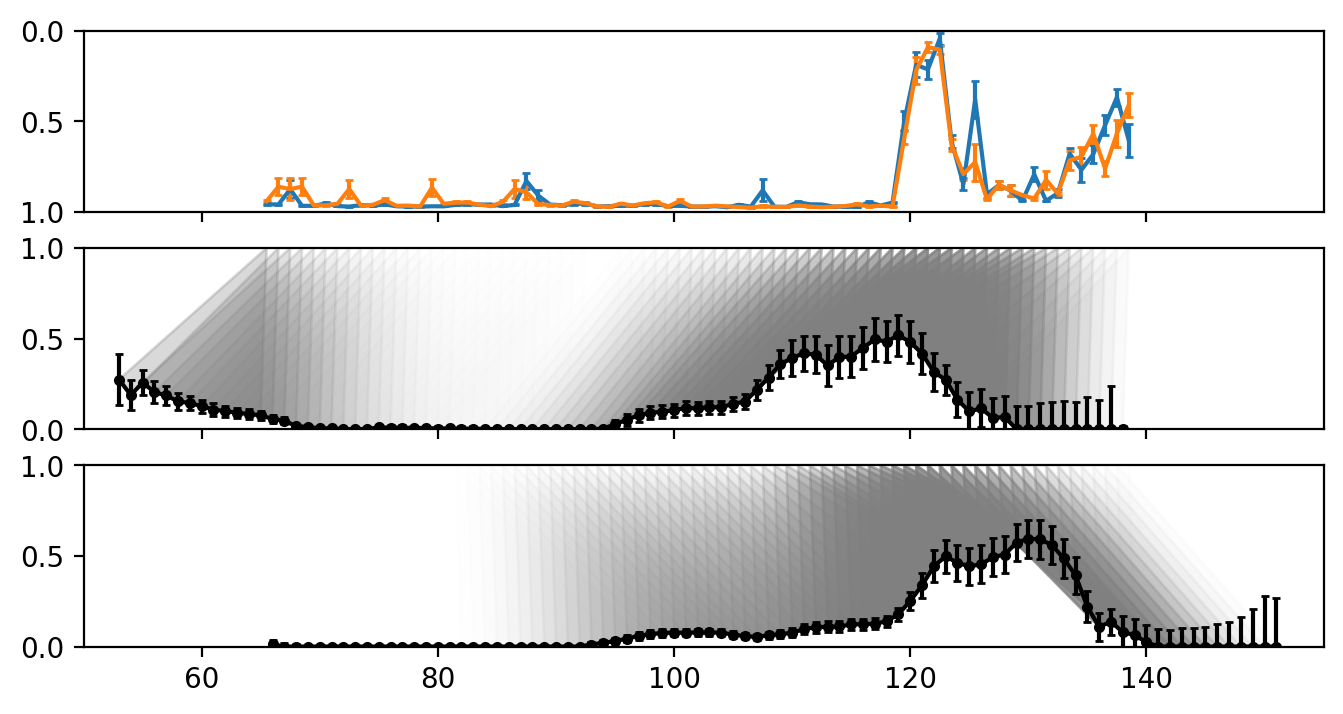

In [10]:
def scale_mm(x, xmin, xmax):
    return((x - xmin) / (xmax - xmin))

fig, axs = plt.subplots(3, 1, figsize=(8,4), sharex=True)

x = np.arange(len(orig_seq))

# insertion phenotype (only unstructured variants)
axs[0].errorbar(x-0.5, insertion_l_mea, yerr=insertion_l_std, capsize=1.5)
axs[0].errorbar(x-0.5, insertion_r_mea, yerr=insertion_r_std, capsize=1.5)
axs[0].set_ylim([1, 0])

# structure impact score
axs[1].errorbar(x, blsc_scor_l_mea, yerr=blsc_scor_l_std, capsize=1.5, fmt='.-k')

shade_offset = 1

alphas = scale_mm(blsc_scor_l_mea, 0, np.nanmax(blsc_scor_l_mea))
for pos in x[np.isfinite(blsc_scor_l_mea)]+1:
    shade_x = list(range(pos-13, pos))+[pos-0.5, pos-13]
    shade_y = list(blsc_scor_l_mea[pos-13:pos])+[shade_offset, blsc_scor_l_mea[pos-13]]
    alpha =  np.mean(alphas[pos-13:pos])
    axs[1].fill(shade_x, shade_y, color='gray', alpha=alpha if alpha==alpha else 0)

axs[2].errorbar(x, blsc_scor_r_mea, yerr=blsc_scor_r_std, capsize=1.5, fmt='.-k')

alphas = scale_mm(blsc_scor_r_mea, 0, np.nanmax(blsc_scor_r_mea))
for pos in x[np.isfinite(blsc_scor_r_mea)]+1:
    shade_x = list(range(pos, pos+13))+[pos+13, pos-0.5]
    shade_y = list(blsc_scor_r_mea[pos:pos+13])+[blsc_scor_r_mea[pos+13], shade_offset]
    alpha =  np.mean(alphas[pos:pos+13])
    axs[2].fill(shade_x, shade_y, color='gray', alpha=alpha if alpha==alpha else 0)

axs[1].set_ylim([0, 1])
axs[2].set_ylim([0, 1])
plt.setp(axs, xlim=[50, 155])
plt.show()